In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from networkx.utils import py_random_state
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

## Bulding the Network

In [2]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

## Contact Tracing Process

In [3]:
def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]


def contact_tracing(G, alpha, p):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Q = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'Q')

    return [len(S)/N, len(I)/N, len(R)/N, len(Q)/N, len(R)/N + p* len(Q)/N]


def quarantine_infection(infected_node, G, alpha, p):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['type'] = 'Q'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes

## Finding The Susceptibility Curves

The coefficient of variation $\chi$, a.k.a susceptibility, is the ratio of the standard deviation to the mean of the ensemble of outbreak sizes

In [4]:
normal = lambda vector: vector/np.max(vector)
suss = lambda N, size_ensemble: (np.sum(size_ensemble**2 - np.max(size_ensemble)**2))/(N - np.max(size_ensemble))


def critical_dictionary(c, alpha, res = 0.025):
    '''
        returns the critical p_c from the mean-field approximation
        for given a network (c) and alpha value
    '''
    ps = np.array(np.load('critP.npy'))
    alphas = np.array(np.load('critA.npy')[c-2])
    ps = ps[~np.isnan(alphas)]
    alphas = alphas[~np.isnan(alphas)]
    
    if alpha < np.max(alphas):
        p_crit = ps[np.where((alphas > alpha-res) & (alphas < alpha+res))[0]][0]
    else:
        p_crit = np.nan
    return p_crit

def p_range_finder(c, alpha, step = .05, numbers = 20):
    '''
        returns a range of ps around the critical p_c from the mean-field approximation
        for given a network (c) and alpha value
    '''
    p_c = critical_dictionary(c, alpha)
    if not np.isnan(p_c):
        return np.linspace(p_c - step + 0.02, p_c + step + c*.02, numbers)

    
def x_exctre(xx, yy):
    '''
        returns the x value for the extrem point of a function yy(xx)
    '''
    return xx[np.where(yy == np.max(yy))[0][0]]    

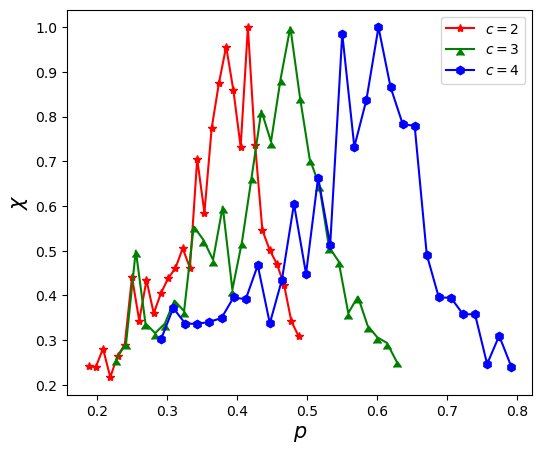

In [8]:
def plot_e_p_sus(N, average_degree, alpha, c_1_list, ens=12):
    Gs = [regular_clique(N, average_degree, c) for c in c_1_list]
    outbreak_size = lambda p_range, G, alpha: [contact_tracing(G, alpha, p)[4] for p in p_range]
    sizes = [np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(outbreak_size)(p_range_finder(c, alpha), Gs[c-2], alpha) for en in range(ens))) for c in c_1_list] 
    #np.save(str(N)+'_'+str(alpha)+'_sus', sizes)
    
    outbreak_size_data = [np.mean(item, axis = 0) for item in sizes] 
    sus_data = [np.std(item, axis = 0)/np.mean(item, axis = 0) for item in sizes]
    
    fig, axs = plt.subplots(1,1, figsize=(6, 5))
    
    colors = ['r', 'g', 'b', 'm'] 

    axs.plot(p_range_finder(2, alpha), normal(sus_data[0]), marker ='*', label = r'$c = 2$',  color = colors[0])
    axs.plot(p_range_finder(3, alpha), normal(sus_data[1]), marker = 6, label =r'$c = 3$', color = colors[1])
    axs.plot(p_range_finder(4, alpha), normal(sus_data[2]), marker= 'h', label = r'$c = 4$', color = colors[2])

    axs.set_xlabel(r'$p$', fontsize = 15)
    axs.set_ylabel(r'$\chi$', fontsize = 15)
    axs.legend()
    #plt.savefig(str(N)+'_'+str(alpha)+'_sus8_.pdf')   

average_degree = 6 
c_1_list = [2,3,4]

p_range = np.linspace(0.0,1.00, 60)
alpha = 0.5

ens = 10**2
N = 2*10**4

plot_e_p_sus(N, average_degree, alpha, c_1_list, ens=ens)

## Loading from data

0.3946743295019157
0.4621595262974574
0.6018599791013584


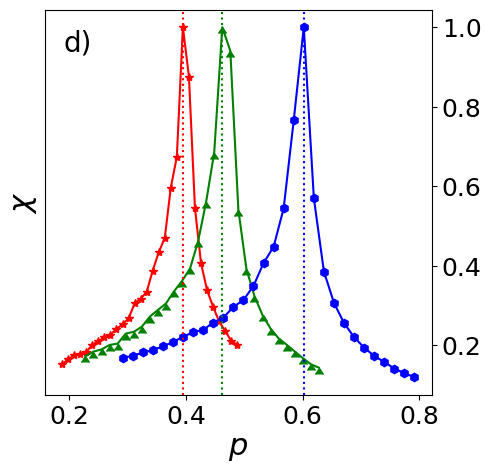

In [7]:
def critical_dictionary(c, alpha, res = 0.025):
    '''
        returns the critical p_c from the mean-field approximation
        for given a network (c) and alpha value
    '''
    ps = np.array(np.load('critP.npy'))
    alphas = np.array(np.load('critA.npy')[c-2])
    ps = ps[~np.isnan(alphas)]
    alphas = alphas[~np.isnan(alphas)]
    
    if alpha < np.max(alphas):
        p_crit = ps[np.where((alphas > alpha-res) & (alphas < alpha+res))[0]][0]
    else:
        p_crit = np.nan
    return p_crit

def p_range_finder(c, alpha, step = .05, numbers = 20):
    '''
        returns a range of ps around the critical p_c from the mean-field approximation
        for given a network (c) and alpha value
    '''
    p_c = critical_dictionary(c, alpha)
    if not np.isnan(p_c):
        return np.linspace(p_c - step + 0.02, p_c + step + c*.02, numbers)

    
def x_exctre(xx, yy):
    '''
        returns the x value for the extrem point of a function yy(xx)
    '''
    return xx[np.where(yy == np.max(yy))[0][0]]    
def p_range_finder(c, alpha, step = .2):
    ps = np.load('mfield_p.npy')
    alphas =  np.load('mfield_a.npy')
    a = alphas[c-2]
    p_c = ps[np.where((a > alpha-step) & (a < alpha+step))[0]][0]
    return np.linspace(p_c - .1 , p_c + .1*c, 30)
    #return np.linspace(p_c - .1 , p_c + .1*c + .2*alpha, 30)
    

ens = 10**4
N = 7*10**5
average_degree = 6 
c_1_list = [2,3,4]

alpha = 0.5

sizes = np.load(str(N)+'_'+str(alpha)+'_sus.npy')
outbreak_size_data = [np.mean(item, axis = 0) for item in sizes] 
sus_data = [np.std(item, axis = 0)/np.mean(item, axis = 0) for item in sizes]
    
fig, axs = plt.subplots( figsize=(5, 5))
    
colors = ['r', 'g', 'b', 'm'] 
axs.plot(p_range_finder(2, alpha), normal(sus_data[0]), marker ='*', label = r'$c = 2$',  color = colors[0])
print(x_exctre(p_range_finder(2, alpha), sus_data[0]))
axs.plot(p_range_finder(3, alpha), normal(sus_data[1]), marker = 6, label =r'$c = 3$', color = colors[1])
print(x_exctre(p_range_finder(3, alpha), sus_data[1]))
axs.plot(p_range_finder(4, alpha), normal(sus_data[2]), marker= 'h', label = r'$c = 4$', color = colors[2])
print(x_exctre(p_range_finder(4, alpha), sus_data[2]))
    
axs.axvline(x = x_exctre(p_range_finder(2, alpha), sus_data[0]), color = colors[0], linestyle='dotted')
axs.axvline(x = x_exctre(p_range_finder(3, alpha), sus_data[1]), color = colors[1], linestyle='dotted')
axs.axvline(x = x_exctre(p_range_finder(4, alpha), sus_data[2]), color = colors[2], linestyle='dotted')

axs.set_xlabel(r'$p$', fontsize = 22)
axs.set_ylabel(r'$\chi$', fontsize = 22)
#axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
#axs.legend()
axs.tick_params(axis='x', labelsize=18)
axs.tick_params(axis='y', labelsize=18)
axs.text(0.05, 0.95, 'd)', transform=axs.transAxes, fontsize=20, va='top')
plt.savefig('3b.pdf',bbox_inches='tight')   

## This code also generates markers for Fig 10.
By running the code on large networks and large ensembels we get the following data:

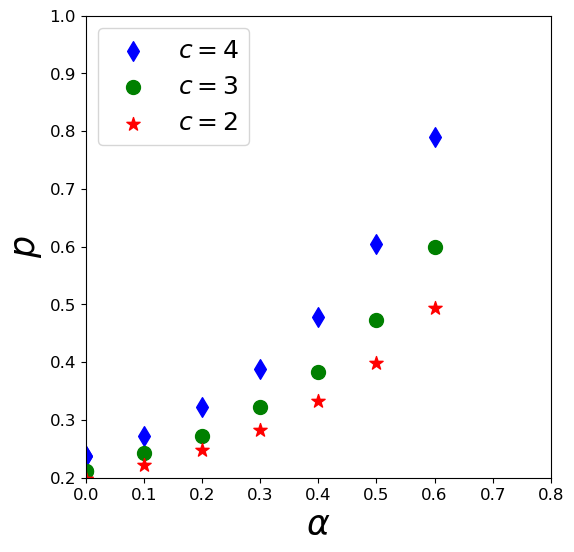

In [45]:
ALPHAS = np.load('ALPHAS.npy')
PA = np.load('PA.npy')


fig, axs = plt.subplots(figsize=(6,6))
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']


for _j in range(len(PA)):
    #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'd', s = 100, color = cr[2])
    axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = 'o', s = 100, color = cr[1])
    axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 100, color =cr[0])
    
    if  _j == 0:
        #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
        axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'd', s = 100, color = cr[2], label=r"$c="+str(4)+"$")
        axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = 'o', s = 100, color = cr[1], label=r"$c="+str(3)+"$" )
        axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 100, color =cr[0], label=r"$c="+str(2)+"$")


axs.set_ylim([0.2, 1])
axs.set_xlim([0.0, .8])

axs.set_ylabel(r'$p$' , fontsize = 25)
axs.set_xlabel(r'$\alpha$' , fontsize = 25)
axs.tick_params(axis='y', labelsize= 12)
axs.tick_params(axis='x', labelsize= 12)
axs.legend(fontsize = 18)
plt.savefig('mfields.pdf')

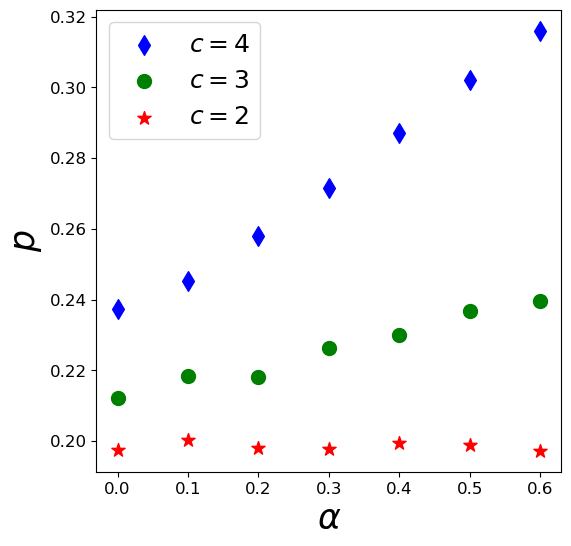

In [44]:
fig, axs = plt.subplots(figsize=(6,6))
for _j in range(len(PA)):
    if _j != 0:
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 100, color =cr[0])
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = 'o', s = 100, color = cr[1])
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'd', s = 100, color = cr[2])
    else:
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'd', s = 100, color = cr[2], label=r"$c="+str(4)+"$", )
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = 'o', s = 100, color = cr[1], label=r"$c="+str(3)+"$", )
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 100, color =cr[0], label=r"$c="+str(2)+"$", )



axs.set_ylabel(r'$p$' , fontsize = 25)
axs.set_xlabel(r'$\alpha$' , fontsize = 25)
axs.tick_params(axis='y', labelsize= 12)
axs.tick_params(axis='x', labelsize= 12)
axs.legend(fontsize = 18)
plt.savefig('mfields.pdf')